In [13]:
# ===== Cell 1: Upload and preview berlin52.tsp =====
from google.colab import files
import os

print("Please upload the 'berlin52.tsp' file:")

# 1) Upload the berlin52.tsp file from your laptop
#    After you run this cell, click "Choose Files" and select berlin52.tsp
uploaded = files.upload()

# Get the filename (automatically detects whatever you uploaded)
filename = next(iter(uploaded))
print("Uploaded file:", filename)

# 2) Check that the file exists in the Colab environment
print("File exists on Colab:", os.path.exists(filename))

# 3) Print the first 15 lines to verify it's a TSPLIB file
print("\nFirst 15 lines of the file:\n")
with open(filename, "r") as f:
    for _ in range(15):
        line = f.readline()
        if not line:
            break
        print(line.strip())

Please upload the 'berlin52.tsp' file:


Saving berlin52.tsp to berlin52 (1).tsp
Uploaded file: berlin52 (1).tsp
File exists on Colab: True

First 15 lines of the file:

NAME: berlin52
TYPE: TSP
COMMENT: 52 locations in Berlin (Groetschel)
DIMENSION: 52
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 565.0 575.0
2 25.0 185.0
3 345.0 750.0
4 945.0 685.0
5 845.0 655.0
6 880.0 660.0
7 25.0 230.0
8 525.0 1000.0
9 580.0 1175.0


In [14]:
# ===== Cell 2: obj and fitness and dist matrix Functions & Data arranging =====
import math
import random
import statistics
import matplotlib.pyplot as plt

def read_tsp_file(fname):
    """Reads the uploaded TSP file and returns a list of id (x, y) coordinates."""
    coords = []
    with open(fname, 'r') as f:
        lines = f.readlines()

    start_reading = False
    for line in lines:
        if "NODE_COORD_SECTION" in line:
            start_reading = True
            continue
        if "EOF" in line:
            break
        if start_reading:
            parts = line.strip().split()
            # We look for lines with ID X Y
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords
#for easy distance acees

def get_distance_matrix(city_list):
    """Pre-calculates distances between all cities."""
    n = len(city_list)
    matrix = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                # Euclidean distance func
                dist = math.sqrt((city_list[i][0] - city_list[j][0])**2 +
                                 (city_list[i][1] - city_list[j][1])**2)
                matrix[i][j] = dist
    return matrix
# obj func is dist: calc tour distance from city 1 back to it
def calculate_tour_distance(tour, matrix):
    total_dist = 0.0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)] # Connect last city back to first
        total_dist += matrix[from_city][to_city]
    return total_dist

# fitness is 1/ dist  making it max op
def calculate_fitness(tour, matrix):

    dist = calculate_tour_distance(tour, matrix)
    if dist == 0: return float('inf')
    return 1.0 / dist

# Load the Data using the filename from Cell 1
cities = read_tsp_file(filename)
dist_matrix = get_distance_matrix(cities)
NUM_CITIES = len(cities)

print(f"Successfully loaded {NUM_CITIES} cities from {filename}.")

Successfully loaded 52 cities from berlin52 (1).tsp.


In [15]:
# Cell 3: GA Operators functions

# 1. Initialize random indisual solution
def create_individual():
    tour = list(range(NUM_CITIES))
    random.shuffle(tour)
    return tour
# used the randoms in 1 to create full pop of pop size
def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

# 2. Tournament Selection pick k randoms and return the best one
def tournament_selection(population, k, matrix):

    candidates = random.sample(population, k)

    # Find the best
    best_candidate = candidates[0]
    best_fit = calculate_fitness(best_candidate, matrix)

    for cand in candidates[1:]:
        fit = calculate_fitness(cand, matrix)
        if fit > best_fit: # Maximization fitness
            best_fit = fit
            best_candidate = cand

    return best_candidate

# 3. Order One Crossover (OX1)
def order_crossover(parent1, parent2):

    size = len(parent1)

    #  two random cut points
    cut1, cut2 = sorted(random.sample(range(size), 2))

    child = [None] * size

    # Copy from Parent 1
    child[cut1:cut2+1] = parent1[cut1:cut2+1]

    # Fill remaining from Parent 2 without repating
    current_pos = (cut2 + 1) % size
    for city in parent2:
        if city not in child[cut1:cut2+1]: # Only add if not already in section
            # Find next empty spot to fill
            while child[current_pos] is not None:
                current_pos = (current_pos + 1) % size
            child[current_pos] = city

    return child

# 4. Swap Mutation 2 random cities
def swap_mutation(tour):
    idx1, idx2 = random.sample(range(len(tour)), 2)
    tour[idx1], tour[idx2] = tour[idx2], tour[idx1]
    return tour

In [16]:
# //////  Main GA //////

def run_genetic_algorithm(pop_size, k_tournament, pc, pm, switch_count, ss_replace, generations):
    """
    Genetic Algorithm for TSP using:
    - Generational replacement (no elitism) at first
    - After 'switch_count' generations with no improvement, switch to
      steady-state replacement: replace 'ss_replace' worst individuals per generation.
    Fitness = 1 / distance (larger is better), but we track distances for reporting.
    """

    # 0) Initialize random population
    population = create_population(pop_size)

    global_best_dist = float('inf')
    global_best_tour = None

    # List to store convergence data
    history = []

    # Start with generational mode
    mode = "generational"
    no_improvement_count = 0

    for gen in range(generations):
        # 1) Evaluate population: (individual, fitness)
        pop_with_fitness = [
            (ind, calculate_fitness(ind, dist_matrix))   # fitness = 1 / distance
            for ind in population
        ]
        # Sort descending: best (largest fitness) first
        pop_with_fitness.sort(key=lambda x: x[1], reverse=True)

        # Get best individual of this generation
        current_best_tour = pop_with_fitness[0][0]
        current_best_dist = calculate_tour_distance(current_best_tour, dist_matrix)

        # Average distance for info
        tour_distances = [
            calculate_tour_distance(ind, dist_matrix) for ind, _ in pop_with_fitness
        ]
        current_avg_dist = statistics.mean(tour_distances)

        # 2) Update global best & stagnation counter
        if current_best_dist < global_best_dist:
            global_best_dist = current_best_dist
            global_best_tour = current_best_tour.copy()
            no_improvement_count = 0          # reset stagnation
        else:
            no_improvement_count += 1         # no improvement this generation

        # 3) Save convergence info
        history.append({
            'generation': gen,
            'best_length': current_best_dist,
            'avg_length': current_avg_dist,
            'mode': mode,
            'stagnation_count': no_improvement_count
        })

        # 4) Check if we should switch to steady-state
        if mode == "generational" and no_improvement_count >= switch_count:
            mode = "steady_state"
            print(f"Switching to steady-state at generation {gen}")

        # 5) Create next generation based on mode
        if mode == "generational":
            # ===== GENERATIONAL (NO ELITISM) =====
            new_population = []

            while len(new_population) < pop_size:
                # Selection (tournament)
                p1 = tournament_selection(population, k_tournament, dist_matrix)
                p2 = tournament_selection(population, k_tournament, dist_matrix)

                # Crossover
                if random.random() < pc:
                    child = order_crossover(p1, p2)
                else:
                    child = list(p1)

                # Mutation
                if random.random() < pm:
                    child = swap_mutation(child)

                new_population.append(child)

            population = new_population

        else:
            # ===== STEADY-STATE: replace 'ss_replace' worst individuals =====

            # Work with the sorted population (best -> worst)
            population = [ind for (ind, _) in pop_with_fitness]

            for _ in range(ss_replace):
                # Selection
                p1 = tournament_selection(population, k_tournament, dist_matrix)
                p2 = tournament_selection(population, k_tournament, dist_matrix)

                # Crossover
                if random.random() < pc:
                    child = order_crossover(p1, p2)
                else:
                    child = list(p1)

                # Mutation
                if random.random() < pm:
                    child = swap_mutation(child)

                # Replace current worst (smallest fitness)
                worst_idx = min(
                    range(len(population)),
                    key=lambda i: calculate_fitness(population[i], dist_matrix)
                )
                population[worst_idx] = child

    return global_best_dist, history, global_best_tour


In [17]:
# Cell: Hyperparameter Tuning (7 variables, 3 values each, 5 runs each)

import statistics
import pandas as pd

def tune_parameters():
    print("Hyperparameter Tuning (5 runs per value)")

    # Baseline defaults
    defaults = {
        "pop_size": 100,
        "k": 3,
        "pc": 0.8,
        "pm": 0.05,
        "switch_count": 200,
        "ss_replace": 2
    }

    # Parameters to test (one at a time)
    tests = [
        ("Population Size",  "pop_size",     [50, 100, 200]),
        ("Tournament K",     "k",            [2, 5, 10]),
        ("Crossover Pc",     "pc",           [0.6, 0.8, 0.95]),
        ("Mutation Pm",      "pm",           [0.01, 0.05, 0.1]),
        ("Switch Count",     "switch_count", [100, 200, 300]),
        ("SS Replace Count", "ss_replace",   [1, 2, 3])
    ]

    detailed_rows = []   # for each run
    summary_rows = []    # avg/std for each value

    for param_name, key, values in tests:
        print(f"\nTesting {param_name}:")
        print(f"{'Value':<10} | {'Avg Dist':<12} | {'Std Dev':<10}")
        print("-" * 38)

        for val in values:
            results = []

            for run_idx in range(1, 6):   # 5 runs per value
                current_args = defaults.copy()
                current_args[key] = val

                best_d, _, _ = run_genetic_algorithm(
                    pop_size=current_args["pop_size"],
                    k_tournament=current_args["k"],
                    pc=current_args["pc"],
                    pm=current_args["pm"],
                    switch_count=current_args["switch_count"],
                    ss_replace=current_args["ss_replace"],
                    generations=500   # you can make this 1000, but 500 is faster for tuning
                )
                results.append(best_d)

                detailed_rows.append({
                    "Parameter": param_name,
                    "Key": key,
                    "Value": val,
                    "Run": run_idx,
                    "Best_Distance": best_d
                })

            avg_val = statistics.mean(results)
            std_val = statistics.stdev(results) if len(results) > 1 else 0

            summary_rows.append({
                "Parameter": param_name,
                "Key": key,
                "Value": val,
                "Avg_Best_Distance": avg_val,
                "Std_Best_Distance": std_val
            })

            print(f"{str(val):<10} | {avg_val:<12.2f} | {std_val:<10.2f}")

    detailed_df = pd.DataFrame(detailed_rows)
    summary_df = pd.DataFrame(summary_rows)

    print("\n================ DETAILED RESULTS (each run) ================")
    display(detailed_df)

    print("\n================ SUMMARY RESULTS (avg & std per value) ================")
    display(summary_df)

    return detailed_df, summary_df

detailed_results_df, summary_results_df = tune_parameters()


Hyperparameter Tuning (5 runs per value)

Testing Population Size:
Value      | Avg Dist     | Std Dev   
--------------------------------------
Switching to steady-state at generation 484
Switching to steady-state at generation 453
Switching to steady-state at generation 441
50         | 11096.41     | 257.11    
100        | 10034.25     | 235.31    
200        | 9327.46      | 415.18    

Testing Tournament K:
Value      | Avg Dist     | Std Dev   
--------------------------------------
Switching to steady-state at generation 334
Switching to steady-state at generation 394
Switching to steady-state at generation 440
Switching to steady-state at generation 318
Switching to steady-state at generation 403
2          | 14787.84     | 886.15    
5          | 9115.40      | 260.29    
10         | 9214.57      | 256.86    

Testing Crossover Pc:
Value      | Avg Dist     | Std Dev   
--------------------------------------
0.6        | 9317.97      | 289.00    
Switching to steady-state at

,Parameter,Key,Value,Run,Best_Distance
0,Population Size,pop_size,50.0,1,11266.902864
1,Population Size,pop_size,50.0,2,11118.980970
2,Population Size,pop_size,50.0,3,10704.427027
3,Population Size,pop_size,50.0,4,11371.106766
4,Population Size,pop_size,50.0,5,11020.651876
...,...,...,...,...,...
85,SS Replace Count,ss_replace,3.0,1,9420.975439
86,SS Replace Count,ss_replace,3.0,2,11261.999661
87,SS Replace Count,ss_replace,3.0,3,10340.052526
88,SS Replace Count,ss_replace,3.0,4,10216.551453



================ SUMMARY RESULTS (avg & std per value) ================


,Parameter,Key,Value,Avg_Best_Distance,Std_Best_Distance
0,Population Size,pop_size,50.00,11096.413901,257.111611
1,Population Size,pop_size,100.00,10034.247484,235.311068
2,Population Size,pop_size,200.00,9327.464343,415.180004
3,Tournament K,k,2.00,14787.837233,886.146353
4,Tournament K,k,5.00,9115.404371,260.292751
5,Tournament K,k,10.00,9214.568324,256.863748
6,Crossover Pc,pc,0.60,9317.968861,288.998323
7,Crossover Pc,pc,0.80,10016.328396,526.694398
8,Crossover Pc,pc,0.95,12400.516261,280.185746
9,Mutation Pm,pm,0.01,9564.750353,446.788284


In [18]:
# ===== Cell: Hyperparameter Tuning STAGE 2 (refinement around Stage 1 best) =====
'''
import statistics
import pandas as pd

def tune_parameters_stage2():
    print("STAGE 2 Hyperparameter Tuning (5 runs per value)")
    print("Using Stage 1 best values as new defaults.\n")

    # Stage 1 best values as new defaults
    defaults_stage2 = {
        "pop_size": 100,     # from Stage 1
        "k": 10,
        "pc": 0.95,
        "pm": 0.05,
        "switch_count": 300,
        "ss_replace": 1
    }

    # Refined ranges around Stage 1 best
    tests_stage2 = [
        ("Population Size",  "pop_size",     [100, 150, 300]),
        ("Tournament K",     "k",            [3, 5, 7]),
        ("Crossover Pc",     "pc",           [0.90, 0.95, 0.99]),
        ("Mutation Pm",      "pm",           [0.03, 0.05, 0.10]),
        ("Switch Count",     "switch_count", [50, 100, 150]),
        ("SS Replace Count", "ss_replace",   [2, 3, 4])
    ]

    detailed_rows = []   # each run
    summary_rows = []    # avg/std per value

    for param_name, key, values in tests_stage2:
        print(f"\nTesting {param_name} (Stage 2):")
        print(f"{'Value':<10} | {'Avg Dist':<12} | {'Std Dev':<10}")
        print("-" * 38)

        for val in values:
            results = []

            for run_idx in range(1, 6):   # 5 runs per value
                current_args = defaults_stage2.copy()
                current_args[key] = val

                best_d, _, _ = run_genetic_algorithm(
                    pop_size=current_args["pop_size"],
                    k_tournament=current_args["k"],
                    pc=current_args["pc"],
                    pm=current_args["pm"],
                    switch_count=current_args["switch_count"],
                    ss_replace=current_args["ss_replace"],
                    generations=500   # still 500 for tuning; final runs use 1000
                )
                results.append(best_d)

                detailed_rows.append({
                    "Stage": "Stage 2",
                    "Parameter": param_name,
                    "Key": key,
                    "Value": val,
                    "Run": run_idx,
                    "Best_Distance": best_d
                })

            avg_val = statistics.mean(results)
            std_val = statistics.stdev(results) if len(results) > 1 else 0

            summary_rows.append({
                "Stage": "Stage 2",
                "Parameter": param_name,
                "Key": key,
                "Value": val,
                "Avg_Best_Distance": avg_val,
                "Std_Best_Distance": std_val
            })

            print(f"{str(val):<10} | {avg_val:<12.2f} | {std_val:<10.2f}")

    detailed_df_stage2 = pd.DataFrame(detailed_rows)
    summary_df_stage2 = pd.DataFrame(summary_rows)

    print("\n================ STAGE 2 DETAILED RESULTS (each run) ================")
    display(detailed_df_stage2)

    print("\n================ STAGE 2 SUMMARY RESULTS (avg & std per value) ================")
    display(summary_df_stage2)

    return detailed_df_stage2, summary_df_stage2

detailed_results_stage2_df, summary_results_stage2_df = tune_parameters_stage2()

'''


STAGE 2 Hyperparameter Tuning (5 runs per value)
Using Stage 1 best values as new defaults.


Testing Population Size (Stage 2):
Value      | Avg Dist     | Std Dev   
--------------------------------------
100        | 8805.95      | 387.69    
150        | 8563.16      | 114.94    
300        | 8424.52      | 147.05    

Testing Tournament K (Stage 2):
Value      | Avg Dist     | Std Dev   
--------------------------------------
3          | 12427.12     | 507.41    
5          | 9176.99      | 175.84    
7          | 8711.00      | 324.33    

Testing Crossover Pc (Stage 2):
Value      | Avg Dist     | Std Dev   
--------------------------------------
0.9        | 8925.00      | 370.61    
0.95       | 9053.89      | 395.78    
0.99       | 8800.47      | 333.65    

Testing Mutation Pm (Stage 2):
Value      | Avg Dist     | Std Dev   
--------------------------------------
0.03       | 8810.26      | 260.42    
0.05       | 8913.54      | 301.23    
0.1        | 8934.49      | 262.

,Stage,Parameter,Key,Value,Run,Best_Distance
0,Stage 2,Population Size,pop_size,100.0,1,8147.469446
1,Stage 2,Population Size,pop_size,100.0,2,8871.278927
2,Stage 2,Population Size,pop_size,100.0,3,8893.112358
3,Stage 2,Population Size,pop_size,100.0,4,8941.200894
4,Stage 2,Population Size,pop_size,100.0,5,9176.705864
...,...,...,...,...,...,...
85,Stage 2,SS Replace Count,ss_replace,4.0,1,8314.299607
86,Stage 2,SS Replace Count,ss_replace,4.0,2,8876.374804
87,Stage 2,SS Replace Count,ss_replace,4.0,3,8792.174217
88,Stage 2,SS Replace Count,ss_replace,4.0,4,8280.548153



================ STAGE 2 SUMMARY RESULTS (avg & std per value) ================


,Stage,Parameter,Key,Value,Avg_Best_Distance,Std_Best_Distance
0,Stage 2,Population Size,pop_size,100.00,8805.953498,387.690115
1,Stage 2,Population Size,pop_size,150.00,8563.155431,114.940887
2,Stage 2,Population Size,pop_size,300.00,8424.521420,147.050745
3,Stage 2,Tournament K,k,3.00,12427.121209,507.409336
4,Stage 2,Tournament K,k,5.00,9176.986279,175.844358
5,Stage 2,Tournament K,k,7.00,8711.002753,324.327013
6,Stage 2,Crossover Pc,pc,0.90,8925.003501,370.609423
7,Stage 2,Crossover Pc,pc,0.95,9053.889545,395.780491
8,Stage 2,Crossover Pc,pc,0.99,8800.472877,333.651115
9,Stage 2,Mutation Pm,pm,0.03,8810.263002,260.418703


In [19]:
import time

# Default parameters (same as tuning defaults)
DEFAULT_POP_SIZE      = 100
DEFAULT_K_TOURNAMENT  = 3
DEFAULT_PC            = 0.8
DEFAULT_PM            = 0.05
DEFAULT_SWITCH_COUNT  = 200
DEFAULT_SS_REPLACE    = 2
DEFAULT_GENERATIONS   = 1000   # full runs

def run_with_params_10_runs(pop_size, k_tournament, pc, pm, switch_count, ss_replace, generations, title=""):
    print(title)
    best_distances = []
    times = []

    for i in range(10):
        start = time.time()
        best_dist, _, _ = run_genetic_algorithm(
            pop_size,
            k_tournament,
            pc,
            pm,
            switch_count,
            ss_replace,
            generations
        )
        elapsed = time.time() - start

        best_distances.append(best_dist)
        times.append(elapsed)

        print(f"Run {i+1}: Best Distance = {best_dist:.2f}, Time = {elapsed:.3f} s")

    best_overall = min(best_distances)
    avg_best = statistics.mean(best_distances)
    avg_time = statistics.mean(times)

    print("\nAFTER 10 RUNS (Summary):")
    print(f"Best Distance among all runs: {best_overall:.2f}")
    print(f"Average Best Distance: {avg_best:.2f}")
    print(f"Average Execution Time (s): {avg_time:.3f}")

    return best_distances, times, best_overall, avg_best, avg_time

# Baseline (before tuning)
baseline_results = run_with_params_10_runs(
    DEFAULT_POP_SIZE,
    DEFAULT_K_TOURNAMENT,
    DEFAULT_PC,
    DEFAULT_PM,
    DEFAULT_SWITCH_COUNT,
    DEFAULT_SS_REPLACE,
    DEFAULT_GENERATIONS,
    title="BEFORE TUNING (Default Parameters)"
)


BEFORE TUNING (Default Parameters)
Run 1: Best Distance = 8543.33, Time = 8.781 s
Switching to steady-state at generation 576
Run 2: Best Distance = 9934.22, Time = 5.613 s
Switching to steady-state at generation 300
Run 3: Best Distance = 11369.65, Time = 3.990 s
Switching to steady-state at generation 667
Run 4: Best Distance = 9693.38, Time = 6.886 s
Switching to steady-state at generation 712
Run 5: Best Distance = 8988.59, Time = 5.741 s
Switching to steady-state at generation 580
Run 6: Best Distance = 10385.77, Time = 6.403 s
Run 7: Best Distance = 8267.31, Time = 7.726 s
Run 8: Best Distance = 8561.13, Time = 10.586 s
Switching to steady-state at generation 467
Run 9: Best Distance = 10243.27, Time = 5.886 s
Switching to steady-state at generation 367
Run 10: Best Distance = 10655.27, Time = 4.649 s

AFTER 10 RUNS (Summary):
Best Distance among all runs: 8267.31
Average Best Distance: 9664.19
Average Execution Time (s): 6.626


In [20]:
# Fill these with the values you choose from summary_results_df
BEST_POP_SIZE      = 100   # example
BEST_K_TOURNAMENT  = 10     # example
BEST_PC            = 0.95  # example
BEST_PM            = 0.05  # example
BEST_SWITCH_COUNT  = 300   # example
BEST_SS_REPLACE    = 1     # example
BEST_GENERATIONS   = 1000

tuned_results = run_with_params_10_runs(
    BEST_POP_SIZE,
    BEST_K_TOURNAMENT,
    BEST_PC,
    BEST_PM,
    BEST_SWITCH_COUNT,
    BEST_SS_REPLACE,
    BEST_GENERATIONS,
    title="AFTER TUNING (Best Parameters)"
)


AFTER TUNING stage 1 (Best Parameters)
Run 1: Best Distance = 8449.57, Time = 17.526 s
Run 2: Best Distance = 8534.27, Time = 18.856 s
Switching to steady-state at generation 947
Run 3: Best Distance = 8043.33, Time = 16.332 s
Run 4: Best Distance = 8500.81, Time = 18.429 s
Run 5: Best Distance = 8694.30, Time = 17.102 s
Run 6: Best Distance = 8127.67, Time = 17.075 s
Switching to steady-state at generation 976
Run 7: Best Distance = 8170.67, Time = 17.902 s
Run 8: Best Distance = 8212.73, Time = 17.084 s
Switching to steady-state at generation 502
Run 9: Best Distance = 9433.74, Time = 10.223 s
Run 10: Best Distance = 8467.22, Time = 17.139 s

AFTER 10 RUNS (Summary):
Best Distance among all runs: 8043.33
Average Best Distance: 8463.43
Average Execution Time (s): 16.767


In [22]:
# 1 seprate to draw convergance graph
best_dist_conv, convergence_history, best_tour_conv = run_genetic_algorithm(
    BEST_POP_SIZE,
    BEST_K_TOURNAMENT,
    BEST_PC,
    BEST_PM,
    BEST_SWITCH_COUNT,
    BEST_SS_REPLACE,
    BEST_GENERATIONS    # e.g. 1000
)

print(f"Final convergence run - Best Distance: {best_dist_conv:.2f}")

Final convergence run - Best Distance: 8380.72


Convergence Data Sample (First 5 Generations):
 generation  best_length   avg_length         mode  stagnation_count
          0 26263.885030 30290.181623 generational                 0
          1 24537.976464 28226.495666 generational                 0
          2 24129.268201 26603.586441 generational                 0
          3 21783.209419 25293.863896 generational                 0
          4 21783.209419 24314.331978 generational                 1


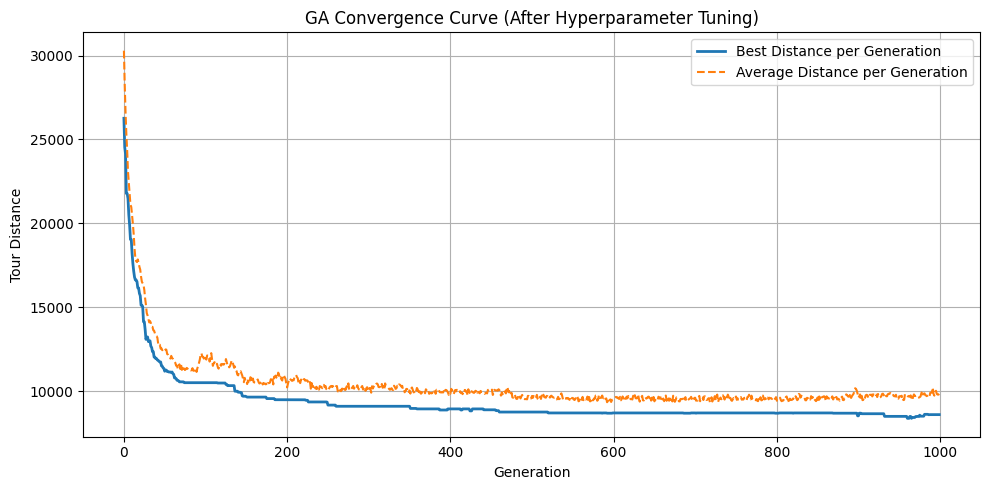

In [23]:
# ===== Convergence Plot (After Tuning) =====

import pandas as pd
import matplotlib.pyplot as plt

# Convert history (list of dicts) to DataFrame
convergence_df = pd.DataFrame(convergence_history)

print("Convergence Data Sample (First 5 Generations):")
print(convergence_df.head().to_string(index=False))

plt.figure(figsize=(10, 5))

# Best distance per generation
plt.plot(
    convergence_df['generation'],
    convergence_df['best_length'],
    label='Best Distance per Generation',
    linewidth=2
)

# Average distance per generation
plt.plot(
    convergence_df['generation'],
    convergence_df['avg_length'],
    label='Average Distance per Generation',
    linestyle='--'
)

# Mark the switch point to steady-state (if it happened)
if 'mode' in convergence_df.columns:
    ss_rows = convergence_df[convergence_df['mode'] == "steady_state"]
    if not ss_rows.empty:
        switch_gen = ss_rows['generation'].iloc[0]
        plt.axvline(
            x=switch_gen,
            linestyle=':',
            label='Switch to Steady-State'
        )

plt.title('GA Convergence Curve (After Hyperparameter Tuning)')
plt.xlabel('Generation')
plt.ylabel('Tour Distance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:

'''
# Fill these with the values you choose from summary_results_df
BEST2_POP_SIZE      = 150   # example
BEST2_K_TOURNAMENT  = 5     # example
BEST2_PC            = 0.99  # example
BEST2_PM            = 0.03 # example
BEST2_SWITCH_COUNT  = 100   # example
BEST2_SS_REPLACE    = 2     # example
BEST2_GENERATIONS   = 1000

tuned_results = run_with_params_10_runs(
    BEST2_POP_SIZE,
    BEST2_K_TOURNAMENT,
    BEST2_PC,
    BEST2_PM,
    BEST2_SWITCH_COUNT,
    BEST2_SS_REPLACE,
    BEST2_GENERATIONS,
    title="AFTER TUNING stage 2 (Best Parameters)"
)
'''


AFTER TUNING stage 2 (Best Parameters)
Switching to steady-state at generation 759
Run 1: Best Distance = 9046.12, Time = 14.038 s
Switching to steady-state at generation 547
Run 2: Best Distance = 8804.69, Time = 10.469 s
Switching to steady-state at generation 484
Run 3: Best Distance = 8289.62, Time = 10.253 s
Switching to steady-state at generation 575
Run 4: Best Distance = 8672.96, Time = 11.332 s
Switching to steady-state at generation 931
Run 5: Best Distance = 7994.30, Time = 15.147 s
Switching to steady-state at generation 743
Run 6: Best Distance = 8762.49, Time = 13.248 s
Switching to steady-state at generation 400
Run 7: Best Distance = 8882.57, Time = 9.373 s
Switching to steady-state at generation 575
Run 8: Best Distance = 8717.94, Time = 11.307 s
Switching to steady-state at generation 491
Run 9: Best Distance = 8342.83, Time = 10.493 s
Switching to steady-state at generation 701
Run 10: Best Distance = 8613.67, Time = 12.690 s

AFTER 10 RUNS (Summary):
Best Distance a

In [10]:
# ===== Convergence Plot (After Tuning) =====
'''
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame
convergence_df = pd.DataFrame(convergence_history)

print("Convergence Data Sample (First 5 Generations):")
print(convergence_df.head().to_string(index=False))

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(
    convergence_df['generation'],
    convergence_df['best_length'],
    label='Best Distance per Generation',
    linewidth=2
)

plt.plot(
    convergence_df['avg_length'],
    label='Average Distance per Generation',
    linestyle='--',
    alpha=0.8
)

# Highlight the switch point (Generational → Steady-State)
if "mode" in convergence_df.columns:
    ss_start = convergence_df[convergence_df['mode'] == "steady_state"].index
    if len(ss_start) > 0:
        ss_start_gen = ss_start[0]
        plt.axvline(x=ss_start_gen, color='red', linestyle=':',
                    label='Switch to Steady-State')

plt.title('GA Convergence Curve (After Parameter Tuning)')
plt.xlabel('Generation')
plt.ylabel('Tour Distance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
'''

NameError: name 'convergence_history' is not defined

In [19]:
#Cell 6: Final Run with best values found
'''
BEST_POP_SIZE = 200
BEST_K = 5
BEST_PC = 0.95
BEST_PM = 0.05
BEST_ELITISM = 2

print("Running Final GA with Best Parameters...")

final_score, convergence_history, final_best_tour = run_genetic_algorithm(
    pop_size=BEST_POP_SIZE,
    k_tournament=BEST_K,
    pc=BEST_PC,
    pm=BEST_PM,
    elitism_count=BEST_ELITISM,
    generations=1000 # Longer run for best result and conv tracking
)

print(f"\nFinal Best Distance Achieved: {final_score:.2f}")'''

Running Final GA with Best Parameters...

Final Best Distance Achieved: 8133.34


In [9]:
# ===== Cell: Convergence Analysis =====
'''
import pandas as pd
import matplotlib.pyplot as plt

# Convert GA history into a DataFrame
convergence_df = pd.DataFrame(convergence_history)

print("Convergence Data Sample (First 5 Generations):")
print(convergence_df.head().to_string(index=False))

# Plotting convergence curve
plt.figure(figsize=(10, 6))

# Best Distance per generation
plt.plot(
    convergence_df['generation'],
    convergence_df['best_length'],
    label='Best Distance (Min)',
    linewidth=2
)

# Average Distance per generation
plt.plot(
    convergence_df['generation'],
    convergence_df['avg_length'],
    label='Average Distance',
    linestyle='--'
)

plt.title('Genetic Algorithm Convergence Over Generations')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'convergence_history' is not defined

In [38]:
# GA BEFORE TUNING
'''
print("Running GA with default hyperparameters...")

default_best_dist, _, default_best_tour = run_genetic_algorithm(
    pop_size=100,
    k_tournament=3,
    pc=0.8,
    pm=0.05,
    elitism_count=2,
    generations=500  # fast run
)

print("\nBEFORE TUNING:")
print("Best Distance:", round(default_best_dist, 2))
print("Best Tour:", default_best_tour)
'''

Running GA with default hyperparameters...

BEFORE TUNING:
Best Distance: 9483.13
Best Tour: [50, 10, 51, 25, 46, 13, 12, 26, 27, 11, 24, 14, 5, 36, 38, 44, 18, 7, 40, 16, 20, 6, 1, 41, 29, 22, 0, 21, 31, 48, 35, 34, 33, 39, 37, 4, 23, 47, 45, 43, 15, 28, 49, 19, 17, 30, 2, 8, 9, 32, 42, 3]


In [29]:
# GA AFTER TUNING
'''
print("\nRunning GA with OPTIMIZED hyperparameters...")

best_best_dist, best_history, best_best_tour = run_genetic_algorithm(
    pop_size=BEST_POP_SIZE,
    k_tournament=BEST_K,
    pc=BEST_PC,
    pm=BEST_PM,
    elitism_count=BEST_ELITISM,
    generations=1000  # long run
)

print("\n AFTER TUNING:")
print("Best Distance:", round(best_best_dist, 2))
print("Best Tour:", best_best_tour)
'''

'\nprint("\nRunning GA with OPTIMIZED hyperparameters...")\n\nbest_best_dist, best_history, best_best_tour = run_genetic_algorithm(\n    pop_size=BEST_POP_SIZE,\n    k_tournament=BEST_K,\n    pc=BEST_PC,\n    pm=BEST_PM,\n    elitism_count=BEST_ELITISM,\n    generations=1000  # long run\n)\n\nprint("\n AFTER TUNING:")\nprint("Best Distance:", round(best_best_dist, 2))\nprint("Best Tour:", best_best_tour)\n'